In [1]:
#Parts of this code were referred from 
#https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


In [6]:
class Config():
    training_dir = "train2/"
    testing_dir = "keras_data/val_dir/"
    train_batch_size = 32
    train_number_epochs = 100

In [7]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [8]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [10]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Scale((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

/opt/Anaconda3-5.0.1/envs/e533/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


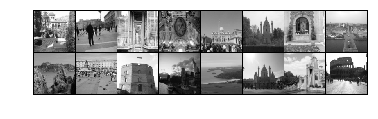

[[1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]]


In [11]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [13]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [15]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [16]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0001 )

In [18]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0).cuda(), Variable(img1).cuda() , Variable(label).cuda()
        output1,output2 = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

Epoch number 0
 Current loss 2.0175483226776123

Epoch number 0
 Current loss 1.1349254846572876

Epoch number 0
 Current loss 1.070145606994629

Epoch number 0
 Current loss 1.0227289199829102

Epoch number 0
 Current loss 1.1490978002548218

Epoch number 0
 Current loss 0.9688879251480103

Epoch number 0
 Current loss 0.9768266677856445

Epoch number 0
 Current loss 1.0957633256912231

Epoch number 0
 Current loss 1.1918007135391235

Epoch number 0
 Current loss 0.9856518507003784

Epoch number 0
 Current loss 1.0226788520812988

Epoch number 0
 Current loss 1.0619081258773804

Epoch number 0
 Current loss 1.0643621683120728

Epoch number 0
 Current loss 0.8726806640625

Epoch number 0
 Current loss 1.211318850517273

Epoch number 0
 Current loss 1.1662158966064453

Epoch number 0
 Current loss 0.9707323312759399

Epoch number 0
 Current loss 1.0905590057373047

Epoch number 0
 Current loss 1.0357569456100464

Epoch number 0
 Current loss 1.0085694789886475

Epoch number 0
 Current l

Epoch number 0
 Current loss 0.8148282766342163

Epoch number 0
 Current loss 1.1558810472488403

Epoch number 0
 Current loss 0.94416344165802

Epoch number 0
 Current loss 0.9362249970436096

Epoch number 0
 Current loss 0.9705020785331726

Epoch number 0
 Current loss 0.7516074180603027

Epoch number 0
 Current loss 1.0199936628341675

Epoch number 0
 Current loss 0.969363808631897

Epoch number 0
 Current loss 0.9187924265861511

Epoch number 0
 Current loss 0.8441939949989319

Epoch number 0
 Current loss 0.7735507488250732

Epoch number 0
 Current loss 1.0795888900756836

Epoch number 0
 Current loss 0.7828949093818665

Epoch number 0
 Current loss 0.8113605380058289

Epoch number 0
 Current loss 0.8597618341445923

Epoch number 0
 Current loss 1.0044755935668945

Epoch number 0
 Current loss 0.7964244484901428

Epoch number 0
 Current loss 0.964077353477478

Epoch number 0
 Current loss 0.8536626696586609

Epoch number 0
 Current loss 0.9015228748321533

Epoch number 0
 Current 

Epoch number 0
 Current loss 1.09220552444458

Epoch number 0
 Current loss 0.7236447334289551

Epoch number 0
 Current loss 1.0159285068511963

Epoch number 0
 Current loss 1.0791176557540894

Epoch number 0
 Current loss 0.931546688079834

Epoch number 0
 Current loss 1.0247784852981567

Epoch number 0
 Current loss 0.9011176228523254

Epoch number 0
 Current loss 0.7899616956710815

Epoch number 0
 Current loss 0.8059049248695374

Epoch number 0
 Current loss 0.9756114482879639

Epoch number 0
 Current loss 0.8153520226478577

Epoch number 0
 Current loss 1.0959054231643677

Epoch number 0
 Current loss 0.8625147342681885

Epoch number 0
 Current loss 1.0150601863861084

Epoch number 0
 Current loss 0.7916765809059143

Epoch number 0
 Current loss 0.9146046042442322

Epoch number 0
 Current loss 0.8546605706214905

Epoch number 0
 Current loss 0.8622742295265198

Epoch number 0
 Current loss 0.9734416007995605

Epoch number 0
 Current loss 0.977651834487915

Epoch number 0
 Current 

Epoch number 0
 Current loss 1.0182163715362549

Epoch number 0
 Current loss 0.8985782265663147

Epoch number 0
 Current loss 0.7004246711730957

Epoch number 0
 Current loss 0.934174656867981

Epoch number 0
 Current loss 0.9617953896522522

Epoch number 0
 Current loss 0.7008811831474304

Epoch number 0
 Current loss 0.8537471294403076

Epoch number 0
 Current loss 0.7677289247512817

Epoch number 0
 Current loss 0.9280033111572266

Epoch number 0
 Current loss 0.5667950510978699

Epoch number 0
 Current loss 0.7850440740585327

Epoch number 0
 Current loss 0.7549892067909241

Epoch number 0
 Current loss 0.938567578792572

Epoch number 0
 Current loss 0.7855533957481384

Epoch number 0
 Current loss 0.7953209280967712

Epoch number 0
 Current loss 0.8958880305290222

Epoch number 0
 Current loss 0.9039895534515381

Epoch number 0
 Current loss 0.8269365429878235

Epoch number 0
 Current loss 1.0132046937942505

Epoch number 0
 Current loss 0.8495071530342102

Epoch number 0
 Curren

Epoch number 0
 Current loss 0.9864808320999146

Epoch number 0
 Current loss 0.78285151720047

Epoch number 0
 Current loss 0.698020339012146

Epoch number 0
 Current loss 0.6571610569953918

Epoch number 0
 Current loss 1.0011494159698486

Epoch number 0
 Current loss 0.7977261543273926

Epoch number 0
 Current loss 0.9368541836738586

Epoch number 0
 Current loss 0.8924756050109863

Epoch number 0
 Current loss 0.9144313335418701

Epoch number 0
 Current loss 0.80784010887146

Epoch number 0
 Current loss 0.787750780582428

Epoch number 0
 Current loss 0.8711704611778259

Epoch number 0
 Current loss 1.0899046659469604

Epoch number 0
 Current loss 0.7350519895553589

Epoch number 0
 Current loss 0.952073335647583

Epoch number 0
 Current loss 0.8884261250495911

Epoch number 0
 Current loss 0.7932831048965454

Epoch number 0
 Current loss 1.008696436882019

Epoch number 0
 Current loss 0.9359967708587646

Epoch number 0
 Current loss 1.0203183889389038

Epoch number 0
 Current loss

Epoch number 0
 Current loss 1.1151572465896606

Epoch number 0
 Current loss 0.8445493578910828

Epoch number 0
 Current loss 0.8613496422767639

Epoch number 0
 Current loss 0.6294410824775696

Epoch number 0
 Current loss 0.9307188391685486

Epoch number 0
 Current loss 0.7204620838165283

Epoch number 0
 Current loss 0.6981268525123596

Epoch number 0
 Current loss 0.803755521774292

Epoch number 0
 Current loss 0.9434490203857422

Epoch number 0
 Current loss 0.7741473913192749

Epoch number 0
 Current loss 0.5227228403091431

Epoch number 0
 Current loss 0.6521124243736267

Epoch number 0
 Current loss 0.9912938475608826

Epoch number 0
 Current loss 0.7361660599708557

Epoch number 0
 Current loss 0.8711612224578857

Epoch number 0
 Current loss 0.9103081822395325

Epoch number 0
 Current loss 0.7516577839851379

Epoch number 0
 Current loss 0.9674400687217712

Epoch number 0
 Current loss 0.8993751406669617

Epoch number 0
 Current loss 0.8983327150344849

Epoch number 0
 Curre

Epoch number 0
 Current loss 0.8167142868041992

Epoch number 0
 Current loss 0.8255499005317688

Epoch number 0
 Current loss 0.7263396978378296

Epoch number 0
 Current loss 0.8147587180137634

Epoch number 0
 Current loss 1.0693483352661133

Epoch number 0
 Current loss 0.8780068159103394

Epoch number 0
 Current loss 0.6859354972839355

Epoch number 0
 Current loss 0.8540237545967102

Epoch number 0
 Current loss 0.6979600787162781

Epoch number 0
 Current loss 0.7294240593910217

Epoch number 0
 Current loss 0.6931760311126709

Epoch number 0
 Current loss 0.6622362732887268

Epoch number 0
 Current loss 0.8413234949111938

Epoch number 0
 Current loss 0.7732775211334229

Epoch number 0
 Current loss 0.909650981426239

Epoch number 0
 Current loss 0.6939184069633484

Epoch number 0
 Current loss 0.9926139116287231

Epoch number 0
 Current loss 0.7006195187568665

Epoch number 0
 Current loss 0.9517902135848999

Epoch number 0
 Current loss 0.8144175410270691

Epoch number 0
 Curre

Epoch number 0
 Current loss 0.6452530026435852

Epoch number 0
 Current loss 0.835448682308197

Epoch number 0
 Current loss 0.5711333751678467

Epoch number 0
 Current loss 0.7716325521469116

Epoch number 0
 Current loss 0.8943334817886353

Epoch number 0
 Current loss 0.8450319170951843

Epoch number 0
 Current loss 0.6916061043739319

Epoch number 0
 Current loss 0.9853072762489319

Epoch number 0
 Current loss 0.6614090204238892

Epoch number 0
 Current loss 0.6121569275856018

Epoch number 0
 Current loss 0.8248903751373291

Epoch number 0
 Current loss 0.7411720752716064

Epoch number 0
 Current loss 0.5798661708831787

Epoch number 0
 Current loss 1.0245444774627686

Epoch number 0
 Current loss 1.0228413343429565

Epoch number 0
 Current loss 0.887779951095581

Epoch number 0
 Current loss 0.6319290995597839

Epoch number 0
 Current loss 0.7382649779319763

Epoch number 0
 Current loss 0.8549671769142151

Epoch number 0
 Current loss 0.85490483045578

Epoch number 0
 Current 

Epoch number 0
 Current loss 0.7207432985305786

Epoch number 0
 Current loss 0.8643928170204163

Epoch number 0
 Current loss 0.768844485282898

Epoch number 0
 Current loss 0.6144816279411316

Epoch number 0
 Current loss 0.8831955194473267

Epoch number 0
 Current loss 0.8820198774337769

Epoch number 0
 Current loss 0.7600423693656921

Epoch number 0
 Current loss 0.68063884973526

Epoch number 0
 Current loss 0.8365021347999573

Epoch number 0
 Current loss 0.9108419418334961

Epoch number 0
 Current loss 0.9698934555053711

Epoch number 0
 Current loss 1.0241698026657104

Epoch number 0
 Current loss 0.8505813479423523

Epoch number 0
 Current loss 0.7536442875862122

Epoch number 0
 Current loss 0.7256389260292053

Epoch number 0
 Current loss 0.8917988538742065

Epoch number 0
 Current loss 0.8325464725494385

Epoch number 0
 Current loss 0.819780707359314

Epoch number 0
 Current loss 0.6326870322227478

Epoch number 0
 Current loss 0.7084106802940369

Epoch number 0
 Current 

Epoch number 0
 Current loss 0.809760332107544

Epoch number 0
 Current loss 0.8074242472648621

Epoch number 0
 Current loss 0.6934908032417297

Epoch number 0
 Current loss 0.8693169951438904

Epoch number 0
 Current loss 0.6927623152732849

Epoch number 0
 Current loss 0.906957745552063

Epoch number 0
 Current loss 0.645942211151123

Epoch number 0
 Current loss 0.7740240693092346

Epoch number 0
 Current loss 0.8102231621742249

Epoch number 0
 Current loss 0.8080780506134033

Epoch number 0
 Current loss 0.8554611802101135

Epoch number 0
 Current loss 0.8905013203620911

Epoch number 0
 Current loss 1.0830024480819702

Epoch number 0
 Current loss 0.8711817860603333

Epoch number 0
 Current loss 0.7975777387619019

Epoch number 0
 Current loss 0.7660940885543823

Epoch number 0
 Current loss 0.8190436363220215

Epoch number 0
 Current loss 0.8434863686561584

Epoch number 0
 Current loss 0.6225191354751587

Epoch number 0
 Current loss 0.871512770652771

Epoch number 0
 Current 

Epoch number 0
 Current loss 0.6973979473114014

Epoch number 0
 Current loss 0.6436946988105774

Epoch number 0
 Current loss 1.0443776845932007

Epoch number 0
 Current loss 0.8456048369407654

Epoch number 0
 Current loss 0.49224433302879333

Epoch number 0
 Current loss 0.8387112021446228

Epoch number 0
 Current loss 0.7918069958686829

Epoch number 0
 Current loss 0.706313967704773

Epoch number 0
 Current loss 0.9880799651145935

Epoch number 0
 Current loss 0.8951144814491272

Epoch number 0
 Current loss 0.8453726172447205

Epoch number 0
 Current loss 0.8198175430297852

Epoch number 0
 Current loss 0.7252698540687561

Epoch number 0
 Current loss 0.9628010392189026

Epoch number 0
 Current loss 1.0402476787567139

Epoch number 0
 Current loss 0.9260098934173584

Epoch number 0
 Current loss 0.69903963804245

Epoch number 0
 Current loss 0.774605929851532

Epoch number 0
 Current loss 0.8447458148002625

Epoch number 0
 Current loss 0.8796221613883972

Epoch number 0
 Current

Epoch number 0
 Current loss 0.9370850920677185

Epoch number 0
 Current loss 0.7284489274024963

Epoch number 0
 Current loss 0.8562931418418884

Epoch number 0
 Current loss 0.6321765780448914

Epoch number 0
 Current loss 0.7967745661735535

Epoch number 0
 Current loss 0.646592378616333

Epoch number 0
 Current loss 0.7008694410324097

Epoch number 0
 Current loss 0.7705883383750916

Epoch number 0
 Current loss 0.9403120875358582

Epoch number 0
 Current loss 0.8996336460113525

Epoch number 0
 Current loss 0.863341212272644

Epoch number 0
 Current loss 0.7882411479949951

Epoch number 0
 Current loss 0.7518510818481445

Epoch number 0
 Current loss 0.7273499369621277

Epoch number 0
 Current loss 0.7223693132400513

Epoch number 0
 Current loss 0.8689713478088379

Epoch number 0
 Current loss 0.9741829633712769

Epoch number 0
 Current loss 0.6673600673675537

Epoch number 0
 Current loss 0.813707172870636

Epoch number 0
 Current loss 0.6623879075050354

Epoch number 0
 Current

Epoch number 0
 Current loss 0.6976820230484009

Epoch number 0
 Current loss 0.7086762189865112

Epoch number 0
 Current loss 0.6671252846717834

Epoch number 0
 Current loss 0.6182938814163208

Epoch number 0
 Current loss 0.5232831239700317

Epoch number 0
 Current loss 0.7778694033622742

Epoch number 0
 Current loss 0.6998124718666077

Epoch number 0
 Current loss 0.8249218463897705

Epoch number 0
 Current loss 0.8079434633255005

Epoch number 0
 Current loss 0.7599674463272095

Epoch number 0
 Current loss 0.696838915348053

Epoch number 0
 Current loss 0.8372491002082825

Epoch number 0
 Current loss 0.6615265607833862

Epoch number 0
 Current loss 0.9812892079353333

Epoch number 0
 Current loss 0.6865111589431763

Epoch number 0
 Current loss 0.7175643444061279

Epoch number 0
 Current loss 0.7841082811355591

Epoch number 0
 Current loss 0.8067287802696228

Epoch number 0
 Current loss 0.8593249320983887

Epoch number 0
 Current loss 0.6959167122840881

Epoch number 0
 Curre

Epoch number 0
 Current loss 0.8502664566040039

Epoch number 0
 Current loss 0.6867614984512329

Epoch number 0
 Current loss 0.7283123731613159

Epoch number 0
 Current loss 0.6507432460784912

Epoch number 0
 Current loss 0.5785796046257019

Epoch number 0
 Current loss 0.7561780214309692

Epoch number 0
 Current loss 0.8021043539047241

Epoch number 0
 Current loss 0.6651320457458496

Epoch number 0
 Current loss 0.5440240502357483

Epoch number 0
 Current loss 0.6185656785964966

Epoch number 0
 Current loss 0.8621023893356323

Epoch number 0
 Current loss 0.9504658579826355

Epoch number 0
 Current loss 0.8163358569145203

Epoch number 0
 Current loss 0.9427242875099182

Epoch number 0
 Current loss 0.8053237199783325

Epoch number 0
 Current loss 0.6740543842315674

Epoch number 0
 Current loss 0.5485225319862366

Epoch number 0
 Current loss 0.8006483912467957

Epoch number 0
 Current loss 0.9547966122627258

Epoch number 0
 Current loss 0.7670642137527466

Epoch number 0
 Curr

Epoch number 0
 Current loss 1.0409646034240723

Epoch number 0
 Current loss 0.7205166816711426

Epoch number 0
 Current loss 0.9086865782737732

Epoch number 0
 Current loss 0.845191240310669

Epoch number 0
 Current loss 0.7954724431037903

Epoch number 0
 Current loss 0.8140339851379395

Epoch number 0
 Current loss 0.6067075729370117

Epoch number 0
 Current loss 0.6974810361862183

Epoch number 0
 Current loss 0.8616661429405212

Epoch number 0
 Current loss 0.6094229817390442

Epoch number 0
 Current loss 0.9276776313781738

Epoch number 0
 Current loss 0.8522462844848633

Epoch number 0
 Current loss 0.6563106775283813

Epoch number 0
 Current loss 0.8684729337692261

Epoch number 0
 Current loss 0.7639683485031128

Epoch number 0
 Current loss 0.6509458422660828

Epoch number 0
 Current loss 0.991034746170044

Epoch number 0
 Current loss 0.662170946598053

Epoch number 0
 Current loss 0.852547824382782

Epoch number 0
 Current loss 0.6102580428123474

Epoch number 0
 Current 

Epoch number 0
 Current loss 0.9457660913467407

Epoch number 0
 Current loss 0.933782696723938

Epoch number 0
 Current loss 0.8476133942604065

Epoch number 0
 Current loss 0.7215704917907715

Epoch number 0
 Current loss 0.8497861623764038

Epoch number 0
 Current loss 0.8609915971755981

Epoch number 0
 Current loss 0.827168881893158

Epoch number 0
 Current loss 0.6492407917976379

Epoch number 0
 Current loss 0.5864192843437195

Epoch number 0
 Current loss 0.8485265374183655

Epoch number 0
 Current loss 0.5740565061569214

Epoch number 0
 Current loss 0.8108335137367249

Epoch number 0
 Current loss 0.9450992941856384

Epoch number 0
 Current loss 0.5904964208602905

Epoch number 0
 Current loss 0.9091634750366211

Epoch number 0
 Current loss 0.8900408148765564

Epoch number 0
 Current loss 0.6925605535507202

Epoch number 0
 Current loss 0.7059963345527649

Epoch number 0
 Current loss 0.783537745475769

Epoch number 0
 Current loss 0.6430221199989319

Epoch number 0
 Current

Epoch number 0
 Current loss 0.7413027882575989

Epoch number 0
 Current loss 1.1047680377960205

Epoch number 0
 Current loss 0.6668474674224854

Epoch number 0
 Current loss 0.7170693874359131

Epoch number 0
 Current loss 0.7977744340896606

Epoch number 0
 Current loss 0.5685625076293945

Epoch number 0
 Current loss 0.8798551559448242

Epoch number 0
 Current loss 0.6949159502983093

Epoch number 0
 Current loss 0.6348226070404053

Epoch number 0
 Current loss 0.7809954285621643

Epoch number 0
 Current loss 0.7941513657569885

Epoch number 0
 Current loss 0.9971683025360107

Epoch number 0
 Current loss 0.6665228605270386

Epoch number 0
 Current loss 0.7352921962738037

Epoch number 0
 Current loss 0.7414537072181702

Epoch number 0
 Current loss 0.7689200043678284

Epoch number 0
 Current loss 0.805364191532135

Epoch number 0
 Current loss 0.7088325023651123

Epoch number 0
 Current loss 0.6567237973213196

Epoch number 0
 Current loss 0.7597609162330627

Epoch number 0
 Curre

Epoch number 0
 Current loss 0.8198035359382629

Epoch number 0
 Current loss 0.819907546043396

Epoch number 0
 Current loss 0.6337867379188538

Epoch number 0
 Current loss 0.6953070163726807

Epoch number 0
 Current loss 0.7463071346282959

Epoch number 0
 Current loss 0.7769309282302856

Epoch number 0
 Current loss 0.6686003804206848

Epoch number 0
 Current loss 0.7262307405471802

Epoch number 0
 Current loss 0.9346640110015869

Epoch number 0
 Current loss 0.6265879273414612

Epoch number 0
 Current loss 0.5549949407577515

Epoch number 0
 Current loss 0.5868745446205139

Epoch number 0
 Current loss 0.6422842741012573

Epoch number 0
 Current loss 0.6098530888557434

Epoch number 0
 Current loss 0.9836085438728333

Epoch number 0
 Current loss 1.200713872909546

Epoch number 0
 Current loss 0.6230347752571106

Epoch number 0
 Current loss 0.7407802939414978

Epoch number 0
 Current loss 0.5761054158210754

Epoch number 0
 Current loss 0.8215527534484863

Epoch number 0
 Curren

Epoch number 0
 Current loss 0.6635986566543579

Epoch number 0
 Current loss 0.6977729797363281

Epoch number 0
 Current loss 1.050472617149353

Epoch number 0
 Current loss 0.8483865857124329

Epoch number 0
 Current loss 0.8940077424049377

Epoch number 0
 Current loss 1.0436521768569946

Epoch number 0
 Current loss 0.7552574872970581

Epoch number 0
 Current loss 0.6573748588562012

Epoch number 0
 Current loss 0.7422412633895874

Epoch number 0
 Current loss 0.8808005452156067

Epoch number 0
 Current loss 0.6250095963478088

Epoch number 0
 Current loss 0.7780792117118835

Epoch number 0
 Current loss 0.7458454370498657

Epoch number 0
 Current loss 0.6938462257385254

Epoch number 0
 Current loss 0.6438400149345398

Epoch number 0
 Current loss 0.671249508857727

Epoch number 0
 Current loss 0.7175210118293762

Epoch number 0
 Current loss 0.6068944931030273

Epoch number 0
 Current loss 0.5383257865905762

Epoch number 0
 Current loss 1.0380947589874268

Epoch number 0
 Curren

Epoch number 0
 Current loss 0.7474351525306702

Epoch number 0
 Current loss 0.7721343040466309

Epoch number 0
 Current loss 0.7749819755554199

Epoch number 0
 Current loss 0.6056821346282959

Epoch number 0
 Current loss 0.651926577091217

Epoch number 0
 Current loss 0.9198080897331238

Epoch number 0
 Current loss 0.8714220523834229

Epoch number 0
 Current loss 0.6499414443969727

Epoch number 0
 Current loss 0.9061468243598938

Epoch number 0
 Current loss 0.7477627992630005

Epoch number 0
 Current loss 0.701074481010437

Epoch number 0
 Current loss 0.6456741690635681

Epoch number 0
 Current loss 0.6936671137809753

Epoch number 0
 Current loss 0.6354008913040161

Epoch number 0
 Current loss 0.7004150152206421

Epoch number 0
 Current loss 0.6631895899772644

Epoch number 0
 Current loss 0.7110444903373718

Epoch number 0
 Current loss 0.7234798669815063

Epoch number 0
 Current loss 0.7759190201759338

Epoch number 0
 Current loss 0.9319814443588257

Epoch number 0
 Curren

Epoch number 0
 Current loss 0.8196302652359009

Epoch number 0
 Current loss 0.7883135080337524

Epoch number 0
 Current loss 0.9562031626701355

Epoch number 0
 Current loss 0.7971269488334656

Epoch number 0
 Current loss 0.6806656718254089

Epoch number 0
 Current loss 0.7748342752456665

Epoch number 0
 Current loss 0.42350566387176514

Epoch number 0
 Current loss 0.6331913471221924

Epoch number 0
 Current loss 0.6695126891136169

Epoch number 0
 Current loss 0.8771953582763672

Epoch number 0
 Current loss 0.9056541323661804

Epoch number 0
 Current loss 0.610173225402832

Epoch number 0
 Current loss 0.7853772044181824

Epoch number 0
 Current loss 0.7366334795951843

Epoch number 0
 Current loss 0.6401320695877075

Epoch number 0
 Current loss 0.5550308227539062

Epoch number 0
 Current loss 0.8663368225097656

Epoch number 0
 Current loss 0.7279074192047119

Epoch number 0
 Current loss 0.7728051543235779

Epoch number 0
 Current loss 0.7408286333084106

Epoch number 0
 Curr

Epoch number 0
 Current loss 0.8082975149154663

Epoch number 0
 Current loss 0.849443793296814

Epoch number 0
 Current loss 0.7020223736763

Epoch number 0
 Current loss 0.7059853076934814

Epoch number 0
 Current loss 0.9293366074562073

Epoch number 0
 Current loss 0.6720110177993774

Epoch number 0
 Current loss 0.6377835273742676

Epoch number 0
 Current loss 0.7505663633346558

Epoch number 0
 Current loss 0.5985645651817322

Epoch number 0
 Current loss 0.7815015912055969

Epoch number 0
 Current loss 0.7353450655937195

Epoch number 0
 Current loss 0.7953943014144897

Epoch number 0
 Current loss 1.0485464334487915

Epoch number 0
 Current loss 0.7174642086029053

Epoch number 0
 Current loss 0.8557952046394348

Epoch number 0
 Current loss 0.9958916902542114

Epoch number 0
 Current loss 0.8694198131561279

Epoch number 0
 Current loss 0.7894365787506104

Epoch number 0
 Current loss 0.864929735660553

Epoch number 0
 Current loss 0.5716022849082947

Epoch number 0
 Current l